Malware image classifier with ResNet101(CNN)
Added Normal class to Malimg dataset

In [ ]:
#cd /content/gdrive/MyDrive/Colab_Notebooks/COEN396_Project

In [ ]:
# !unzip malimg_dataset.zip -d /content/gdrive/MyDrive/Colab_Notebooks/COEN396_Project/malimgData

In [ ]:
pip install split-folders

In [ ]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import splitfolders
import pandas as pd
import seaborn as sns
import os
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.utils import class_weight 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet101
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Model

**No need to run this cell, as we have already uploaded images in normal folder**

In [ ]:
# Specify the path to save the images
save_path = "/kaggle/working/"

# Specify the number of images to generate
num_images = 700

# Specify image properties
image_format = "PNG"
image_mode = "L"
image_size = (256, 346)
min_pixel_value = 0
max_pixel_value = 255
mean_pixel_value = 121.93363890895954

# Create the save directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

for i in range(10):
# #     Create a new image with the specified properties
# #     Uncomment below lines to run
#     pixels = np.random.randint(low=min_pixel_value, high=max_pixel_value+1, size=image_size, dtype=np.uint8)
#     image = Image.fromarray(pixels, mode=image_mode)

# #     Save the image
# #     Uncomment below lines to run
#     image_path = os.path.join(save_path, f"normal_image_{i+1}.png")
#     image.save(image_path)

In [ ]:
#set ratios to split the data
input_folder = '/kaggle/input/malimg-with-normal-class/malimg_paper_dataset_imgs'
output_folder = 'dataset'
splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(0.8, 0.1, 0.1)) 

In [ ]:
#set the image size to 150
img_size = 150

#set the training data
train = ImageDataGenerator().flow_from_directory(directory='dataset/train', target_size=(img_size,img_size), batch_size=10000)

#set the validation data
val = ImageDataGenerator().flow_from_directory(directory='dataset/val', target_size=(img_size,img_size), batch_size=10000)

#set the testing data
test = ImageDataGenerator().flow_from_directory(directory='dataset/test', target_size=(img_size,img_size), batch_size=10000)

In [122]:
train.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Normal': 17,
 'Obfuscator.AD': 18,
 'Rbot!gen': 19,
 'Skintrim.N': 20,
 'Swizzor.gen!E': 21,
 'Swizzor.gen!I': 22,
 'VB.AT': 23,
 'Wintrim.BX': 24,
 'Yuner.A': 25}

In [ ]:
d = train.class_indices

In [ ]:
#show train classes keys
d.keys()

In [123]:
#load train images data and labels
imgs_train, labels_train = next(train)

#load validation images data and labels
imgs_val, labels_val = next(val)

In [124]:
#print the shape of training data
imgs_train.shape

(7907, 150, 150, 3)

In [ ]:
#print the shape of training data lqbels
labels_train.shape

In [125]:
#to visualize some images from the data
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
  
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1

    #to show images 
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(train.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

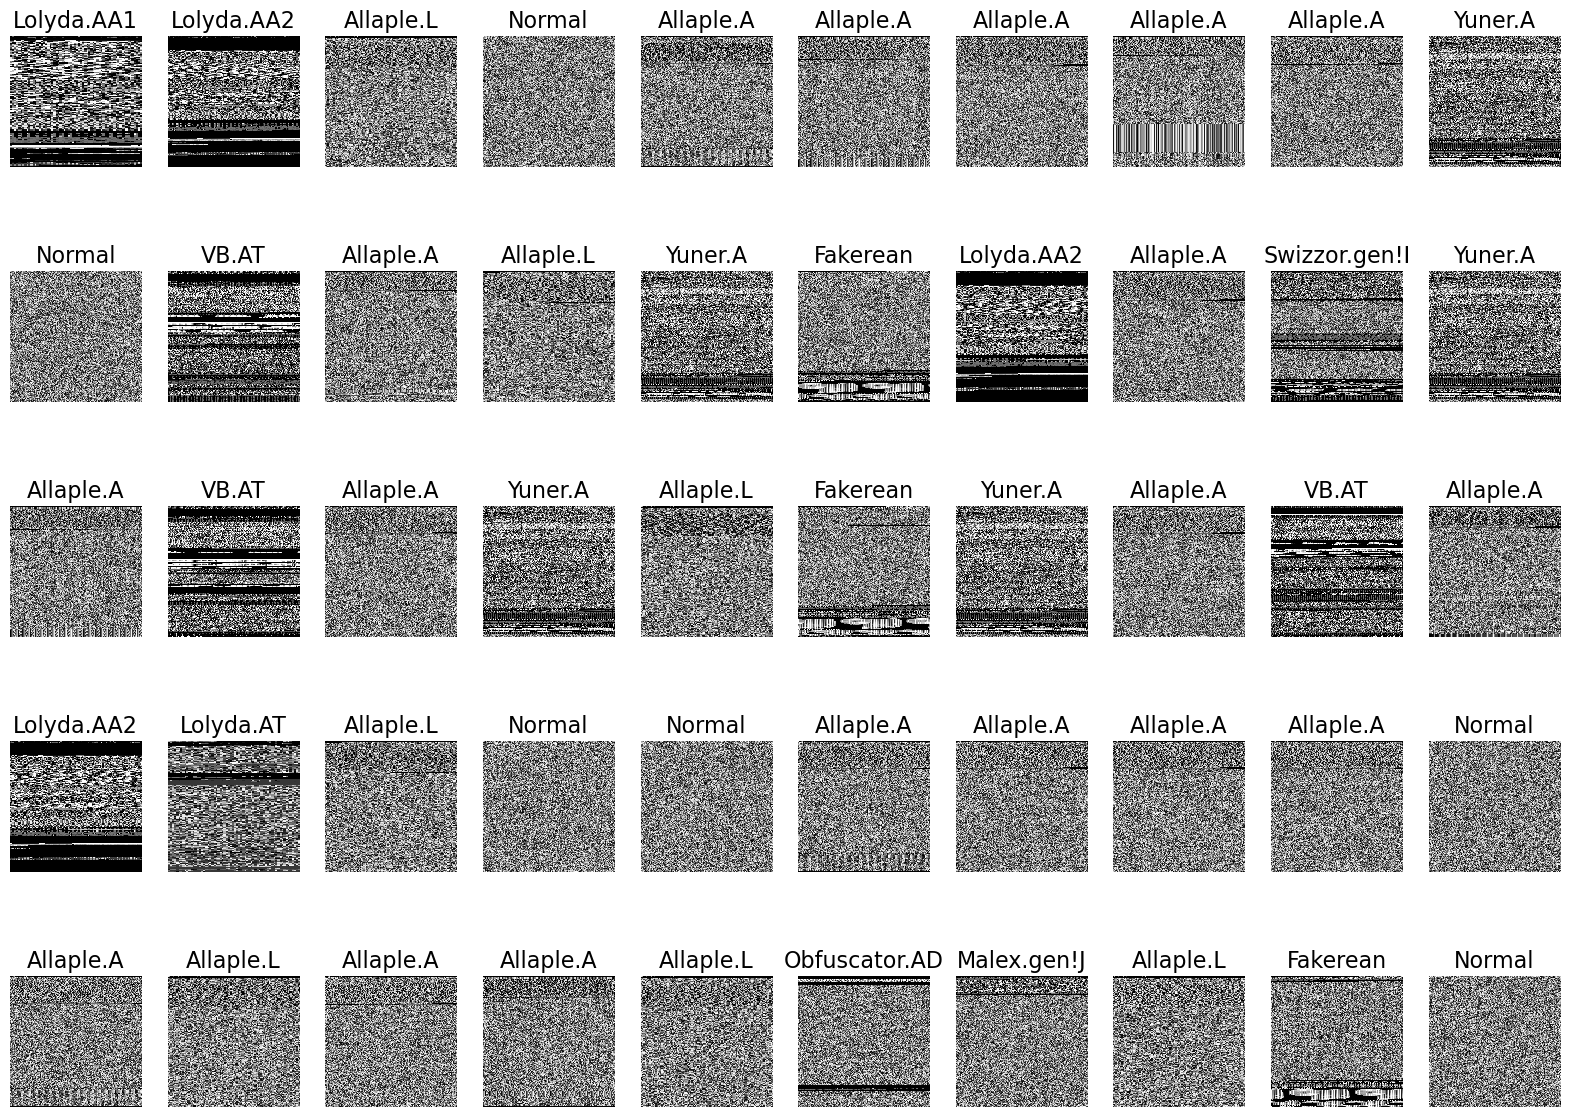

In [126]:
#show the images and their labels
plots(imgs_train, titles = labels_train)

<BarContainer object of 26 artists>

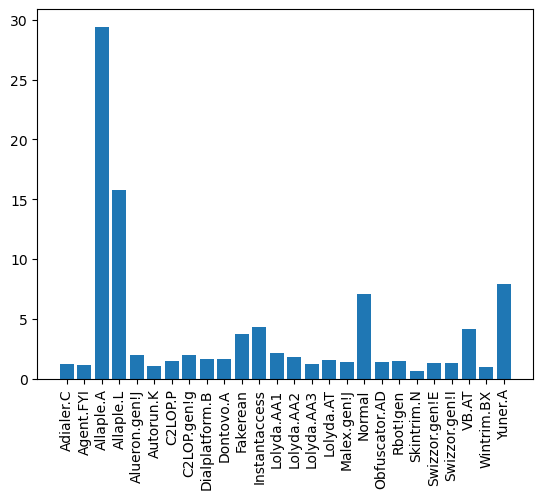

In [127]:
#to print the classes percentage distributions 
classes = train.class_indices.keys()
perc = (sum(labels_train)/labels_train.shape[0])*100

#show the gragh
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [128]:
y_train_new = np.argmax(labels_train, axis=1)
y_train_new

array([12, 13,  3, ...,  3,  2,  7])

In [129]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_new),
                                        y = y_train_new                                                    
                                    )

class_weights = dict(zip(np.unique(y_train_new), y_train_new))
class_weights

{0: 12,
 1: 13,
 2: 3,
 3: 17,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 2,
 9: 25,
 10: 17,
 11: 23,
 12: 2,
 13: 3,
 14: 25,
 15: 10,
 16: 13,
 17: 2,
 18: 22,
 19: 25,
 20: 2,
 21: 23,
 22: 2,
 23: 25,
 24: 3,
 25: 10}

# Baseline Model - Logistic regression:

In [130]:
# Set the path to your malimg dataset
dataset_path = "/kaggle/input/malimg-with-normal-class/malimg_paper_dataset_imgs"

# Load the malimg dataset and extract features
images = []
labels = []

class_mapping = {}  # Map class names to labels

# Read images and labels
for class_label, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):  # Skip if the current item is not a directory
        continue
    
    class_mapping[class_label] = class_name
    
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, 0)  # Load the image as grayscale
        image = cv2.resize(image, (64, 64))  # Resize the image to a consistent size
        images.append(image.flatten())  # Flatten the image into a feature vector
        labels.append(class_label)  # Assign the class label


# Convert the data to NumPy arrays
X_base = np.array(images)
y_base = np.array(labels)

# Split the dataset into training, validation, and testing sets
X_train_base, X_test_val, y_train_base, y_test_val = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
X_test_base, X_val_base, y_test_base, y_val_base = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_base = scaler.fit_transform(X_train_base)
X_val_base = scaler.transform(X_val_base)
X_test_base = scaler.transform(X_test_base)

In [131]:
# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=2000, verbose = 1, n_jobs = 4)

# Train the Logistic Regression classifier
lr_classifier.fit(X_train_base, y_train_base)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       106522     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57976D+04    |proj g|=  2.03546D+03


 This problem is unconstrained.



At iterate   50    f=  1.34651D+01    |proj g|=  1.30927D-01

At iterate  100    f=  1.26653D+01    |proj g|=  5.84962D-02

At iterate  150    f=  1.24926D+01    |proj g|=  8.90812D-02

At iterate  200    f=  1.23934D+01    |proj g|=  1.01490D-02

At iterate  250    f=  1.23886D+01    |proj g|=  9.40937D-03

At iterate  300    f=  1.23845D+01    |proj g|=  9.27518D-03

At iterate  350    f=  1.23735D+01    |proj g|=  8.85983D-03

At iterate  400    f=  1.23703D+01    |proj g|=  6.71196D-03

At iterate  450    f=  1.23678D+01    |proj g|=  4.34559D-03

At iterate  500    f=  1.23664D+01    |proj g|=  3.66209D-03

At iterate  550    f=  1.23656D+01    |proj g|=  5.00948D-03

At iterate  600    f=  1.23649D+01    |proj g|=  3.78647D-03

At iterate  650    f=  1.23646D+01    |proj g|=  3.56113D-03

At iterate  700    f=  1.23643D+01    |proj g|=  4.32195D-03

At iterate  750    f=  1.23638D+01    |proj g|=  3.17444D-03

At iterate  800    f=  1.23636D+01    |proj g|=  2.28379D-03

At iter

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.9min finished


LogisticRegression(max_iter=2000, n_jobs=4, verbose=1)

In [132]:
# Make predictions on the validation set
y_pred_val_base = lr_classifier.predict(X_val_base)

# Calculate evaluation metrics for validation set
accuracy_val_base = metrics.accuracy_score(y_val_base, y_pred_val_base)
precision_val_base = metrics.precision_score(y_val_base, y_pred_val_base, average='weighted')
recall_val_base = metrics.recall_score(y_val_base, y_pred_val_base, average='weighted')
f1_score_val_base = metrics.f1_score(y_val_base, y_pred_val_base, average='weighted')
classification_report_val_base = metrics.classification_report(y_val_base, y_pred_val_base)

# Print the evaluation metrics for validation set
print("Validation Set:")
print("Accuracy:", accuracy_val_base)
print("Precision:", precision_val_base)
print("Recall:", recall_val_base)
print("F1-Score:", f1_score_val_base)
print("\nClassification Report:")
print(classification_report_val_base)


Validation Set:
Accuracy: 0.9686868686868687
Precision: 0.9683821282590482
Recall: 0.9686868686868687
F1-Score: 0.968251710025671

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.71      0.71      0.71         7
           2       0.73      0.80      0.76        20
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        15
           6       1.00      0.99      0.99       148
           7       0.98      0.96      0.97        56
           8       1.00      0.95      0.98        21
           9       1.00      0.91      0.95        23
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         5
          14       0.97      1.00  

In [133]:
# Make predictions on the test set
y_pred_test_base = lr_classifier.predict(X_test_base)
y_proba_test_base = lr_classifier.predict_proba(X_test_base)

# Calculate average precision score
average_precision = metrics.precision_score(y_test_base, y_pred_test_base, average='weighted')

# Calculate evaluation metrics for test set
accuracy_test_base = metrics.accuracy_score(y_test_base, y_pred_test_base)
precision_test_base = metrics.precision_score(y_test_base, y_pred_test_base, average='weighted')
recall_test_base = metrics.recall_score(y_test_base, y_pred_test_base, average='weighted')
f1_score_test_base = metrics.f1_score(y_test_base, y_pred_test_base, average='weighted')
classification_report_test_base = metrics.classification_report(y_test_base, y_pred_test_base)

# Print the evaluation metrics for test set
print("\nTest Set:")
print("Accuracy:", accuracy_test_base)
print("Precision:", precision_test_base)
print("Recall:", recall_test_base)
print("F1-Score:", f1_score_test_base)
print("\nClassification Report:")
print(classification_report_test_base)


Test Set:
Accuracy: 0.9747474747474747
Precision: 0.9754780107988663
Recall: 0.9747474747474747
F1-Score: 0.9746815943902476

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.92      1.00      0.96        12
           2       0.95      0.91      0.93        23
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        44
           5       1.00      1.00      1.00        12
           6       1.00      0.98      0.99       157
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00         6
          14       0.99      1.00      

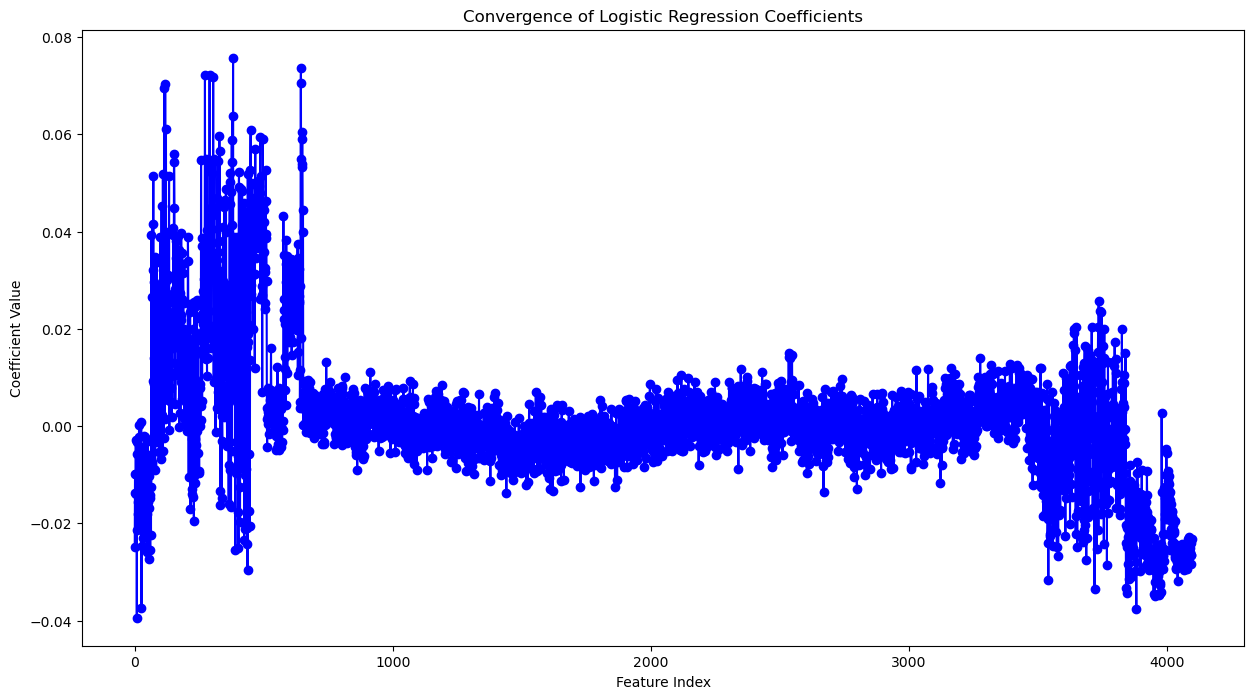

In [134]:
# Plot the accuracy curve
plt.figure(figsize=(15, 8))
plt.plot(range(len(lr_classifier.coef_[0])), lr_classifier.coef_[0], marker='o', linestyle='-', color='blue')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Convergence of Logistic Regression Coefficients')
plt.show()

In [ ]:
# plt.plot(range(len(lr_classifier.n_iter_)), accuracy_test_base, marker='o', linestyle='-', color='red', label='Test Accuracy')
# plt.plot(range(len(lr_classifier.n_iter_)), accuracy_val_base, marker='o', linestyle='-', color='green', label='Validation Accuracy')
# plt.xlabel('Number of Iterations')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Curves (Line Plot)')
# plt.show()


Classification Report For Baseline Model (Logistic Regression):



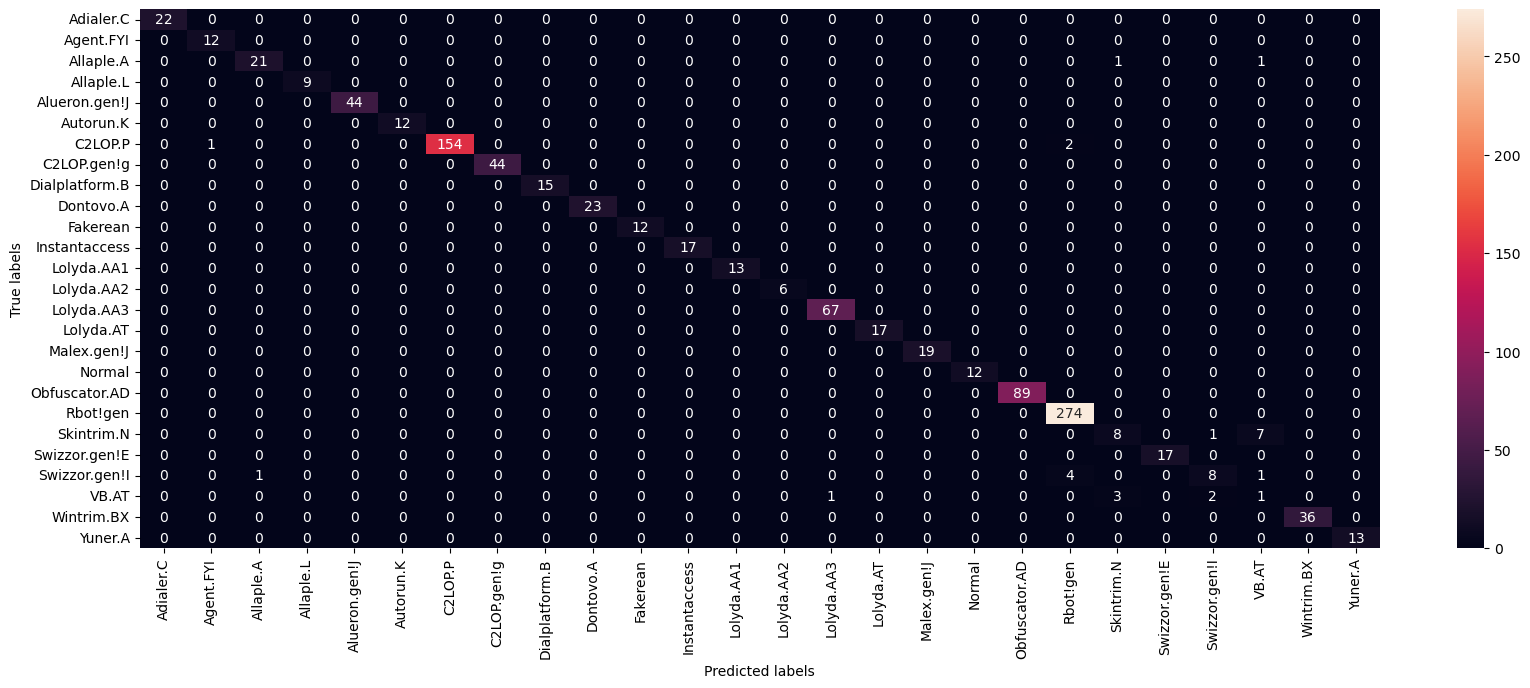

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

#set the images labels
label_names = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Normal', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']

print("Classification Report For Baseline Model (Logistic Regression):\n")
# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test_base, y_pred_test_base)
# Set the figure size
plt.figure(figsize=(20, 7))

# Plot the confusion matrix using a heatmap
try:
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")

# Assign axes labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Display the plot
plt.show()

# CNN: ResNet101 Model

In [136]:
#define a function for ResNet101 model
from tensorflow.keras.models import Model

def malware_model_resNet():
    
    #build the model
    baseModel = ResNet101(weights="imagenet", include_top=False,input_shape=(img_size,img_size,3))

    #make the model as trainable
    for layer in baseModel.layers:
        layer.trainable = False  
     
    #build the model
    headModel = baseModel.output

    #set the maxpooling layer
    headModel = MaxPooling2D(pool_size=(2, 2))(headModel)

    #set a flatten layer
    headModel = Flatten(name="flatten")(headModel)

    #set the dense layer with relu activation
    headModel = Dense(256, activation="relu")(headModel)

    #set a dropout layer
    headModel = Dropout(0.5)(headModel)

    #set output layer with softmax activation function
    headModel = Dense(26, activation="softmax")(headModel)

    #build the model
    model = Model(inputs=baseModel.input, outputs=headModel)

    #compile the model using adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [137]:
Malware_model_ResNet = malware_model_resNet()

171446536/171446536 [==============================] - 1s 0us/step


In [138]:
Malware_model_ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [139]:
#for model check point 
checkpoint_filepath = 'ResNet_Checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#for early stopping
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=0,
    mode="max",
)

#to fit the model
history = Malware_model_ResNet.fit(imgs_train, 
                            labels_train, 
                            validation_data=(imgs_val, labels_val), 
                            epochs=50,  
                            class_weight=class_weights,
                            callbacks=[model_checkpoint_callback,model_early_stopping_callback])

Malware_model_ResNet.load_weights(checkpoint_filepath)

#save the model
Malware_model_ResNet.save("ResNet_final.h5")

Epoch 1/50
248/248 [==============================] - 45s 116ms/step - loss: 5.1679 - accuracy: 0.7758 - val_loss: 0.2841 - val_accuracy: 0.9243
Epoch 2/50
248/248 [==============================] - 25s 103ms/step - loss: 1.6677 - accuracy: 0.8847 - val_loss: 0.1893 - val_accuracy: 0.9488
Epoch 3/50
248/248 [==============================] - 28s 114ms/step - loss: 1.2596 - accuracy: 0.8997 - val_loss: 0.1630 - val_accuracy: 0.9529
Epoch 4/50
248/248 [==============================] - 25s 99ms/step - loss: 1.1097 - accuracy: 0.9116 - val_loss: 0.1894 - val_accuracy: 0.9447
Epoch 5/50
248/248 [==============================] - 27s 110ms/step - loss: 0.9702 - accuracy: 0.9165 - val_loss: 0.1393 - val_accuracy: 0.9488
Epoch 6/50
248/248 [==============================] - 29s 117ms/step - loss: 0.7969 - accuracy: 0.9296 - val_loss: 0.1313 - val_accuracy: 0.9570
Epoch 7/50
248/248 [==============================] - 28s 113ms/step - loss: 1.0985 - accuracy: 0.9187 - val_loss: 0.1714 - val_acc

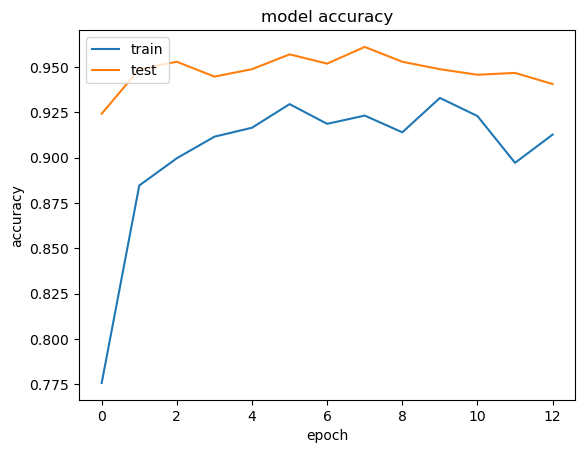

In [140]:
#print the accuracies curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

#set the titles of the plot
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

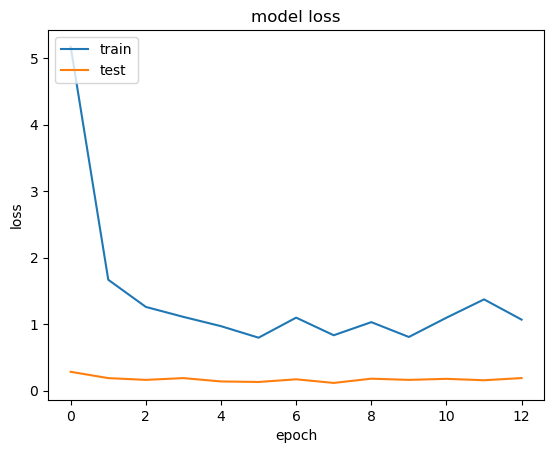

In [141]:
#print the model losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#set the titles of the graph
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [142]:
scores = Malware_model_ResNet.evaluate(imgs_val, labels_val)

31/31 [==============================] - 3s 90ms/step - loss: 0.1170 - accuracy: 0.9611


In [143]:
#print the validation accuracy
print('Final ResNet101 accuracy on validation : ', scores[1])

Final ResNet101 accuracy on validation :  0.9611054062843323


In [144]:
#to calculate the testing accuracy
imgs_test, labels_test = next(test)

In [145]:
scores_test = Malware_model_ResNet.evaluate(imgs_test, labels_test)

32/32 [==============================] - 4s 112ms/step - loss: 0.1108 - accuracy: 0.9655


In [146]:
print('Final ResNet101 accuracy on Testing : ', scores_test[1])

Final ResNet101 accuracy on Testing :  0.9654832482337952


In [147]:
predict_x=Malware_model_ResNet.predict(imgs_test) 
y_pred=np.argmax(predict_x,axis=1)

32/32 [==============================] - 5s 88ms/step


In [148]:
y_test2 = np.argmax(labels_test, axis=1)

In [149]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [150]:
#for plotting the confusion matrix
 
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )

    #to show the confusion matrix plot
    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    #set fontsize and style of confusion matrix
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    #set the titles of the confusion matrix
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

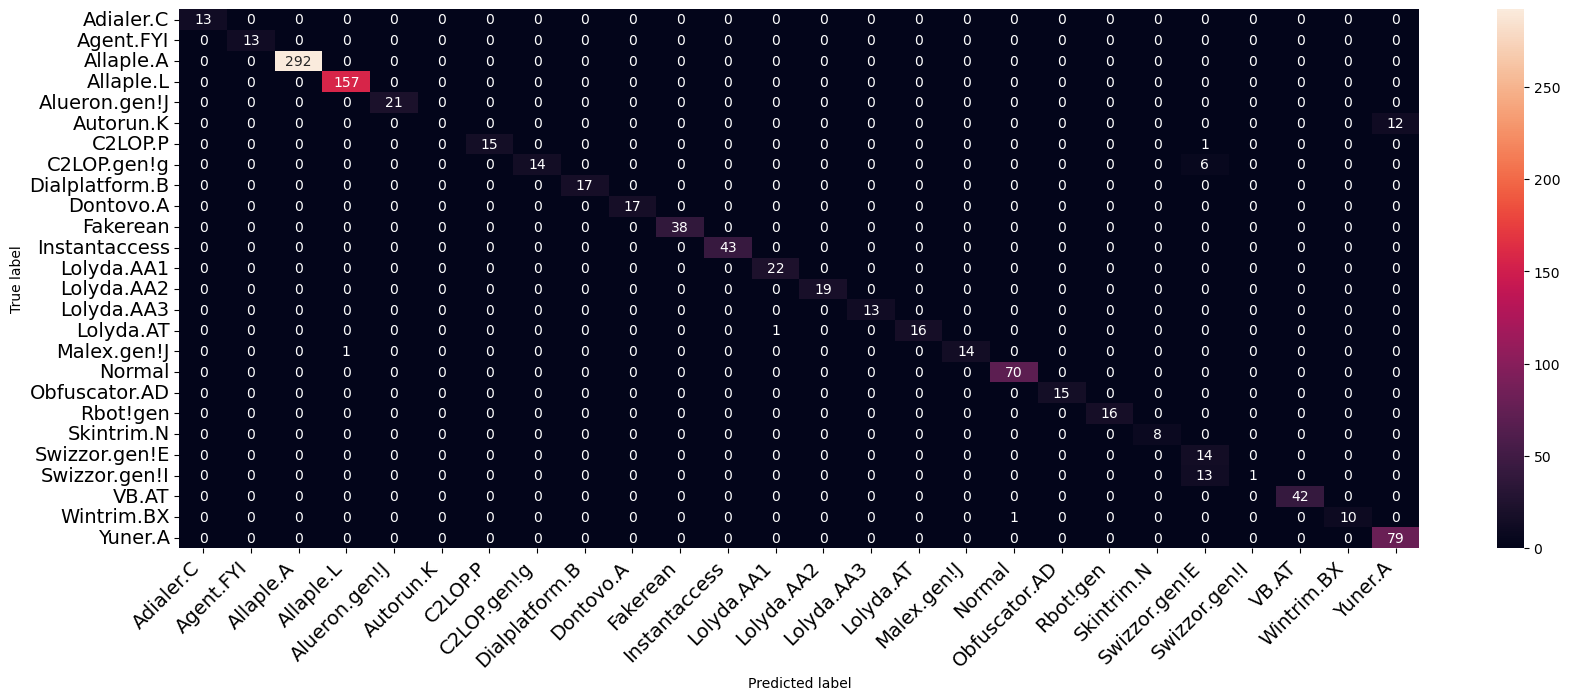

In [151]:
#to print the confusion matrix
class_names= test.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

In [152]:
import tensorflow as tf
path='/kaggle/input/malimg-with-normal-class/malimg_paper_dataset_imgs/Normal/normal_image_100.png'

img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0) 
classes = Malware_model_ResNet.predict(x)
classes = np.argmax(classes)

#set the images labels
label = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J','Normal', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
print(label[classes])

1/1 [==============================] - 1s 554ms/step
Normal


# Convert bytes to images and test against model for predicting the malware class

In [ ]:
dataRaw = "/content/gdrive/MyDrive/Colab_Notebooks/COEN396_Project/dataRaw"

In [ ]:
## This function allows us to process our hexadecimal files into png images##
def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save('\\'+name+'.png', "PNG")
    return im

#Get the list of files
files=os.listdir(dataRaw)
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(dataRaw+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        del array
        f.close()

# Prediting malware class on test image

In [156]:
# Path to the image you want to classify using Logistic regression
image_path = '/kaggle/working/normal_image_2.png'

# Load and preprocess the image
img = tf.keras.utils.load_img(image_path, target_size=(64, 64), color_mode="grayscale")
x_baseline = tf.keras.utils.img_to_array(img)
x_baseline = x_baseline.reshape(1, -1)  # Reshape to 1D array

# Feature scaling
scaler = StandardScaler()
x_baseline = scaler.fit_transform(x_baseline)

# Make predictions using the logistic regression model
y_pred_baseline = lr_classifier.predict(x_baseline)
class_label = y_pred_baseline[0]

# Get the corresponding class name from the mapping
class_name = class_mapping[class_label]

# Print the predicted class name
print("Predicted class:", class_name)

Predicted class: Allaple.A


In [155]:
import tensorflow as tf
path='/kaggle/working/normal_image_2.png'

img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0) 
classes = Malware_model_ResNet.predict(x)
classes = np.argmax(classes)

#set the images labels
label = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
print(label[classes])

1/1 [==============================] - 0s 31ms/step
Obfuscator.AD


In [ ]:
import pandas as pd
import re
from PIL import Image
import os

# Load the CSV file
csv_path = '/kaggle/input/microsoft-malware-sample/test_vec.csv'
data = pd.read_csv(csv_path)

# Create a new folder to store the converted images
output_folder = 'testImages_PostTraining'
os.makedirs(output_folder, exist_ok=True)

# Iterate over each row in the dataset
for index, row in data.iterrows():
    # Extract the hexadecimal values
    hex_values = [re.sub('[^0-9a-fA-F]', '', val) for val in row.iloc[2:].astype(str).tolist()]  # Remove non-hexadecimal characters

    # Ensure each hexadecimal value has an even length
    hex_values = [val if len(val) % 2 == 0 else '0' + val for val in hex_values]

    # Convert hexadecimal values to binary data
    binary_data = bytes.fromhex(''.join(hex_values))

    # Create an image from binary data
    image = Image.frombytes('L', (len(hex_values) // 2, 1), binary_data)

    # Generate a unique filename for the image
    image_filename = f'image_{index}.png'
    image_path = os.path.join(output_folder, image_filename)

    # Save the image
    image.save(image_path)
